#### First I import the needed libraries as below:

In [2]:
from sklearn import cluster, datasets, mixture
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from sklearn.model_selection import train_test_split

I import the **noisy moons** dataset and preprocess the data as below to put it into **pandas** dataframe:

In [3]:
noisy_moons = datasets.make_moons(n_samples=500, noise=0.11)

feature_1 = []
feature_2 = []
for i in range(len(noisy_moons[0])):
    feature_1.append(noisy_moons[0][i][0])
    feature_2.append(noisy_moons[0][i][1])

Data = pd.DataFrame({
    'feature 1': feature_1,
    'feature 2': feature_2,
    'class': noisy_moons[1]
})

labels = Data["class"]

I preprocess the data to implement a **Gaussian model** as below:

In [3]:
X = np.asarray(Data)
y = np.asarray(Data["class"])
y= y.reshape(len(y), )
training_data, testing_data, training_labels, testing_labels = train_test_split(X,y) 

class_0 = []
class_1 = []
for row in training_data:
    if (row[2] == 0):
        class_0.append(row)
    else:
        class_1.append(row)

class_0 = np.delete(class_0, 2, axis=1)
class_1 = np.delete(class_1, 2, axis=1)


I caculate **mean** and **covariance** for each distribution:

In [4]:
def mean_cov_calc(class_i):

    mean_vector = np.average(class_i, axis=0)
    mean_feature_0 = mean_vector[0]
    mean_feature_1 = mean_vector[1]
    
    sum_feature_0 = sum_feature_1 = 0
    for i in range (len(class_i)):
        sum_feature_0 += float(class_i[i][0])
        sum_feature_1 += float(class_i[i][1])

    sigma_0 = sigma_1 = 0
    for i in range (len(class_i)):
        sigma_0 += (float(class_i[i][0]) - mean_feature_0) ** 2
        sigma_1 += (float (class_i[i][1]) - mean_feature_1) ** 2

    var_0 = sigma_0 / (len(class_i))
    var_1 = sigma_1 / (len(class_i))
    cov = 0
    for i in range (len(class_i)):
            cov +=  (float (class_i[i][0]) - mean_feature_0)*(float (class_i[i][1])  - mean_feature_1)
           
    cov /= (len(class_i))
    cov_matrix = [[var_0, cov],
                 [cov, var_1]]

    return mean_vector, cov_matrix

In [5]:
mean_0, cov_0 = mean_cov_calc(class_0)
print("mean of class 0:", mean_0)
print("cov of class 0:", cov_0)
mean_1, cov_1 = mean_cov_calc(class_1)
print("mean of class 1:", mean_1)
print("cov of class 1:", cov_1)

mean of class 0: [0.04687731 0.63012771]
cov of class 0: [[0.5026161341974046, -0.014980329455481625], [-0.014980329455481625, 0.10505516646917418]]
mean of class 1: [ 0.98696738 -0.14261332]
cov of class 1: [[0.5221430428454983, -0.003104636497334427], [-0.003104636497334427, 0.10291468316384425]]


I implement a **prediction function**:

In [6]:
def Gx_calc (test_sample, train_set, class_i):
    test_sample = (test_sample[0:2])
    mean_class_i, cov_class_i = mean_cov_calc(class_i)
    W = np.dot(-0.5, np.linalg.inv(cov_class_i))
    w = np.dot(np.linalg.inv(cov_class_i),mean_class_i)
    A = np.dot(- 0.5 ,np.transpose(mean_class_i))
    B = np.dot(A, np.linalg.inv(cov_class_i))
    w0 = (np.dot(B, mean_class_i)) - 0.5 * np.log(np.linalg.det(cov_class_i)) + np.log(len(class_i) / len(train_set))
    C = np.dot(np.transpose(test_sample), W)
    return (np.dot(C, test_sample) + np.dot(np.transpose(w), test_sample)+ w0)

In [7]:
def decision_make (test_sample, train_set, class_0, class_1):
    G0 = Gx_calc (test_sample, train_set, class_0)
    G1 = Gx_calc (test_sample, train_set, class_1)
    if (G0 >= G1):
        return ('0')
    else:
        return ('1')

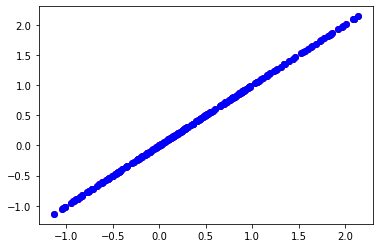

In [8]:
x1 = x2 = y1 = y2 = []
for i in range (len(testing_data)):
    estmation = decision_make (testing_data[i], training_data, class_0, class_1)
    if (estmation == 0):
        x1.append(testing_data[i][0])
        y1.append(testing_data[i][1])
    else:
        x2.append(testing_data[i][0])
        y2.append(testing_data[i][1])

plt.scatter(x1, y1, c='red', label='Zero')
plt.scatter(x2, y2, c='blue', label='One')
plt.show() 

For implementing a GMM model, I first define a class in which I define functions for **E step** and **M step** as below, and finally fit the data:

In [ ]:
from scipy.stats import multivariate_normal

class GMM:
    def __init__(self, k, max_iter=5):
        self.k = k
        self.max_iter = int(max_iter)

    def initialize(self, X):
        self.shape = X.shape
        self.n, self.m = self.shape
        self.phi = np.full(shape=self.k, fill_value=1/self.k)
        self.weights = np.full( shape=self.shape, fill_value=1/self.k)
        random_row = np.random.randint(low=0, high=self.n, size=self.k)
        self.mu = [  X[row_index,:] for row_index in random_row ]
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ]

    def E(self, X):
        self.weights = self.predict_prob(X)
        self.phi = self.weights.mean(axis=0)
    
    def M(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T, 
                aweights=(weight/total_weight).flatten(), 
                bias=True)

    def fit(self, X):
        self.initialize(X)
        for iteration in range(self.max_iter):
            self.E(X)
            self.M(X)
            
    def predict_prob(self, X):
        likelihood = np.zeros( (self.n, self.k) )
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i], cov=self.sigma[i])
            likelihood[:,i] = distribution.pdf(X)
        numerator = likelihood * self.phi
        denominator = numerator.sum(axis=1)[:, np.newaxis]
        weights = numerator / denominator
        return weights
    
    def predict(self, X):
        weights = self.predict_prob(X)
        return np.argmax(weights, axis=1)

I define a **jitter** function and plot the new points:

In [37]:
def jitter(x):
    return x + np.random.uniform(low=-0.05, high=0.05, size=x.shape)

def plot_axis_pairs(X):
    plt.title('GMM Clusters')
    plt.scatter(jitter(X[:, 0]), jitter(X[:, 1]))
    plt.tight_layout()

now we see the results for num of components equal to 3,8,16:

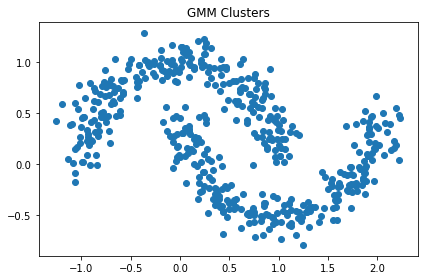

In [41]:
#num of components = 3
gmm = GMM(k=3, max_iter=20)
gmm.fit(X)
plot_axis_pairs(X)

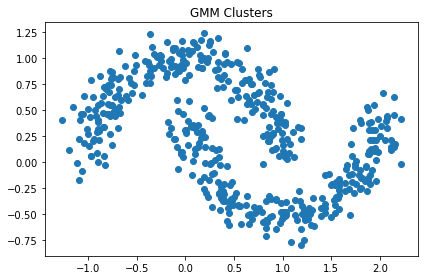

In [42]:
#num of components = 8
gmm = GMM(k=8, max_iter=20)
gmm.fit(X)
plot_axis_pairs(X)

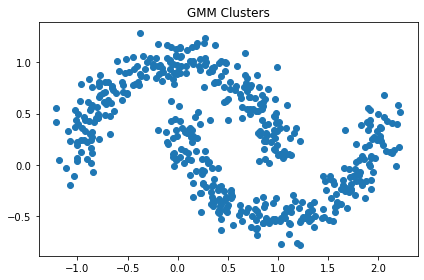

In [43]:
#num of components = 16
gmm = GMM(k=16, max_iter=20)
gmm.fit(X)
plot_axis_pairs(X)

**AIC** and **BIC** graphs for the best num of components.
we know that the best num of components is the one with **lowest** aic and bic scores which as we see is 6.

In [ ]:
aic = []
for k in range(1,101):
    gmm = GMM(k, max_iter=20)
    aic.append(gmm.fit(X).aic(X))
k = np.arange(1,101)
plt.plot(k, aic)
plt.title("aic by num of components")
plt.xlabel("num of components")
plt.ylabel("aic")
plt.show()

In [ ]:
bic = []
for k in range(1,101):
    gmm = GMM(k, max_iter=20)
    bic.append(gmm.fit(X).bic(X))
k = np.arange(1,101)
plt.plot(k, bic)
plt.title("aic by num of components")
plt.xlabel("num of components")
plt.ylabel("aic")
plt.show()